In [2]:
import numpy as np
np.int=int
np.bool=bool
np.object=object
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception,ResNet50,VGG16
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed
from tensorflow.keras.models import Sequential,load_model


In [89]:
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'df': 'Dermatofibroma',
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'vasc': 'Vascular lesions'

}

In [90]:
df=pd.read_csv(r"C:\Users\smura\Downloads\archive (11)\HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [91]:
p1=r"C:\Users\smura\Downloads\archive (11)\HAM10000_images_part_1"
p2=r"C:\Users\smura\Downloads\archive (11)\HAM10000_images_part_2"

In [92]:
def load_img(path1,path2):
    ip={}
    for i in os.listdir(path1):
        ip[i[0:12]]=os.path.join(path1,i)
    for i in os.listdir(path2):
        ip[i[0:12]]=os.path.join(path2,i)
    print(len(ip))
    return ip

In [93]:
ip=load_img(p1,p2)

10015


In [94]:
df['path'] = df['image_id'].map(ip.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [95]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\smura\Downloads\archive (11)\HAM10000...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\smura\Downloads\archive (11)\HAM10000...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\smura\Downloads\archive (11)\HAM10000...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\smura\Downloads\archive (11)\HAM10000...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\smura\Downloads\archive (11)\HAM10000...,Benign keratosis-like lesions,2


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [97]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [98]:
df['age'].fillna((df['age'].mean()), inplace=True)

C:\Users\smura\AppData\Local\Temp\ipykernel_16432\1123070014.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True)


In [99]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [100]:
!pip install opencv-python tqdm
import cv2
from tqdm import tqdm
import os
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(71,71))
  return img
train_img = []
for img_name in tqdm(df['path'].values):
  train_img.append(read_img(img_name))

100%|███████████████████████████████████████████████████████████████████████████| 10015/10015 [01:00<00:00, 165.09it/s]


In [101]:
X = np.array(train_img,np.float32)/255
print(X.shape)

(10015, 71, 71, 3)


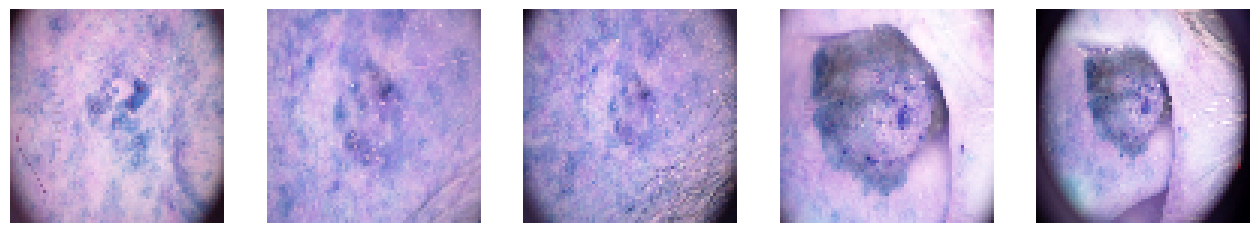

In [102]:
plt.figure(figsize=(16,12))
for i in range(1,6,1):
    plt.subplot(1,5,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [103]:
y = np.array(df['cell_type_idx'])

In [104]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=28,stratify=y)
x_train,x_val,y_train,y_val =   train_test_split(x_train,y_train,test_size=0.10,random_state=28,stratify=y_train)

In [105]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)
y_test=to_categorical(y_test, num_classes=7)

In [20]:
training_shape = (71,71,3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)
for layer in base_model.layers:
    layer.trainable = True

In [21]:
n_classes = 7
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [22]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [23]:
batch_size=32
print(x_train.shape,y_train.shape)
steps_per_epoch = len(x_train) // batch_size
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(8111, 71, 71, 3) (8111, 7)
(8111, 71, 71, 3) (8111, 7)
(902, 71, 71, 3) (902, 7)


In [24]:
n_epoch = 20

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                              verbose=1, mode='auto')

In [25]:
history = model.fit(x_train,
                    y_train,
                    epochs=n_epoch,
                    batch_size=32,
                    verbose=1,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val)
                   )

Epoch 1/20
254/254 [==============================] - 36s 95ms/step - loss: 0.9213 - accuracy: 0.6814 - val_loss: 1.0432 - val_accuracy: 0.7118
Epoch 2/20
254/254 [==============================] - 23s 90ms/step - loss: 0.6626 - accuracy: 0.7703 - val_loss: 1.1122 - val_accuracy: 0.7239
Epoch 3/20
254/254 [==============================] - 25s 97ms/step - loss: 0.5651 - accuracy: 0.8030 - val_loss: 0.8033 - val_accuracy: 0.7328
Epoch 4/20
254/254 [==============================] - 25s 100ms/step - loss: 0.4750 - accuracy: 0.8338 - val_loss: 0.7682 - val_accuracy: 0.7672
Epoch 5/20
254/254 [==============================] - 26s 103ms/step - loss: 0.3882 - accuracy: 0.8718 - val_loss: 0.7191 - val_accuracy: 0.7661
Epoch 6/20
254/254 [==============================] - 27s 105ms/step - loss: 0.3109 - accuracy: 0.8979 - val_loss: 0.9385 - val_accuracy: 0.7483
Epoch 7/20
254/254 [==============================] - 27s 105ms/step - loss: 0.2442 - accuracy: 0.9207 - val_loss: 0.8946 - val_accur

In [26]:
model_json = model.to_json()
with open("slc123.json",'w') as json_file:
    json_file.write(model_json)
model.save("slc123.h5")

D:\anaconda\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [27]:
from keras.models import model_from_json
json_file = open('slc123.json','r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("slc123.h5")

Predicted class: 0
Actinic keratoses


array([[9.9794167e-01, 4.8162480e-04, 9.1282121e-04, 1.9919820e-04,
        4.7418114e-05, 4.1669782e-04, 5.8692370e-07]], dtype=float32)

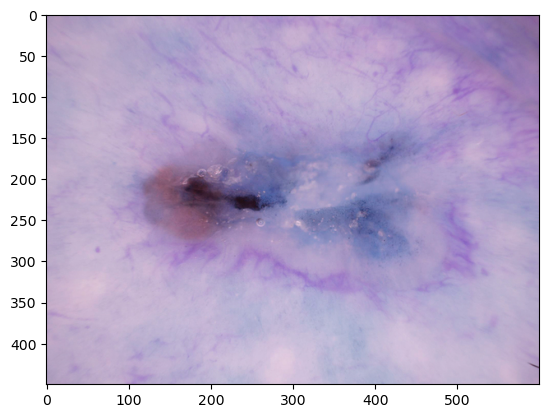

In [28]:
classify = {
    4:'Melanocytic Nevi',
    5: 'Melanoma',
    2: 'Benign keratosis-like lesions ',
    1: 'Basal cell carcinoma',
    0: 'Actinic keratoses',
    6: 'Vascular lesions',
    3: 'Dermatofibroma'

}
img=r"C:\Users\smura\Downloads\archive (11)\HAM10000_images_part_1\ISIC_0025471.jpg"
img1=cv2.imread(img)
plt.imshow(img1)
input_shape = (71,71)
img = cv2.resize(img1, input_shape)
img = np.expand_dims(img, axis=0)
img=img/255
img = np.expand_dims(img, axis=-1)
predictions = model.predict(img)

predicted_class = np.argmax(predictions)

print(f"Predicted class: {predicted_class}")
print(classify[predicted_class])
predictions

In [33]:
model=load_model("slc123.h5")

Predicted class: 2
Benign keratosis-like lesions 


array([[0.24299903, 0.01087912, 0.7091067 , 0.00454509, 0.0082828 ,
        0.02333872, 0.00084854]], dtype=float32)

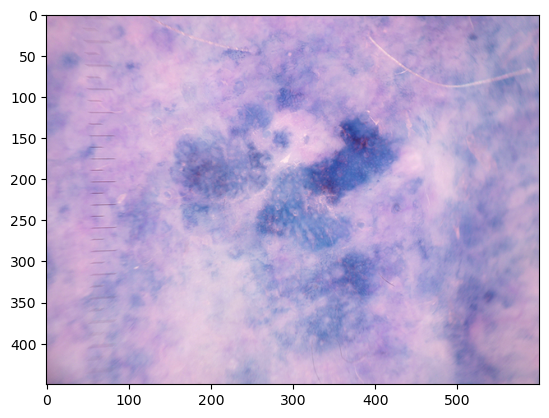

In [7]:
classify = {
    4:'Melanocytic Nevi',
    5: 'Melanoma',
    2: 'Benign keratosis-like lesions ',
    1: 'Basal cell carcinoma',
    0: 'Actinic keratoses',
    6: 'Vascular lesions',
    3: 'Dermatofibroma'

}
img=r"C:\Users\smura\Downloads\archive (11)\HAM10000_images_part_1\ISIC_0027419.jpg"
img1=cv2.imread(img)
plt.imshow(img1)
input_shape = (71,71)
img = cv2.resize(img1, input_shape)
img = np.expand_dims(img, axis=0)
img=img/255
img = np.expand_dims(img, axis=-1)
predictions = model.predict(img)

predicted_class = np.argmax(predictions)

print(f"Predicted class: {predicted_class}")
print(classify[predicted_class])
predictions

In [76]:
y_pred=[]

In [77]:
for i in x_train:
    i = np.expand_dims(i, axis=0)
    predict=model.predict(i)
    prediction_label=np.argmax(predict)
    y_pred.append(prediction_label)
for i in x_val:
    i = np.expand_dims(i, axis=0)
    predict=model.predict(i)
    prediction_label=np.argmax(predict)
    y_pred.append(prediction_label)
for i in x_test:
    i = np.expand_dims(i, axis=0)
    predict=model.predict(i)
    prediction_label=np.argmax(predict)
    y_pred.append(prediction_label)

In [106]:
y=[]


In [107]:

for i in y_train:
    y.append(np.argmax(i))
for i in y_val:
    y.append(np.argmax(i))
for i in y_test:
    y.append(np.argmax(i))

In [111]:
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score
macro_precision = precision_score(y, y_pred, average='macro')
macro_precision

0.938481791121958

In [112]:
from sklearn.metrics import accuracy_score
accuracy_score(y,y_pred)

0.9628557164253619

In [113]:
macro_recall = recall_score(y, y_pred, average='macro')
macro_recall

0.9303206589268985

In [114]:
macro_f1 = f1_score(y, y_pred, average='macro')

macro_f1

0.9341638067199497